## Blood Glucose

By RJ Nowling, 2018-09-06

A [CDC Report](https://www.cdc.gov/media/releases/2017/p0718-diabetes-report.html) "finds that as of 2015, 30.3 million Americans – 9.4 percent of the U.S. population –have diabetes. Another 84.1 million have prediabetes, a condition that if not treated often leads to type 2 diabetes within five years."

When we eat food, carbohydrates in the food are converted into glucose, a type of sugar, that floats in our blood.  In a healthy person, the pancreas and liver regulate the concentration of glucose by releasing insulin and stored glucose, respectively.  Insulin triggers the body's cells to absorb the glucose floating in the blood stream.  Type 2 diabetes is characterized by elevated blood sugar (glucose) levels due to reduced sensitivity to insulin (insulin resistance).  Insulin resistance can be made worse when a person is overweight.  Blood sugar is often measured by a device called a glucometer using a blood sample.

Diet and exercise are used as a first line defense for managing type 2 diabetes or prediabetes.  Diet and exercise impact glucose levels directly and indirectly.  High carbohydrates foods like candy, potatoes, or bread can spike blood sugar levels; foods with complex carbohydrates such as whole wheat bread or sweed potatoes tend to be digested more slowly, leading to smoother blood sugar levels. Exercise can reduce blood sugar levels temporarily by causing cells to absorb glucose in the blood without needing insulin.  Longer term, proper diet and consistent exercise can help type 2 diabetics lose weight and consequently, reduce insulin resistance.

In this notebook, we'll analyze glucose readings from a type 2 diabetic taken over the summer of 2016.  The data set contains a timestamp (date and time), glucose level, and whether or not the person engaged in a physical activity before the reading was taken.  We'll analyze this data set to determine the seasonality in the blood glucose levels and the impact of exercise on blood glucose levels.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

## Loading and Cleaning the Data using Pandas

Read the data from a CSV File

In [2]:
glucose_readings = pd.read_csv("../data/glucose.csv")

Preview the data by looking at the first few rows

In [3]:
glucose_readings.head()

,Timestamp,Blood Glucose,Prior Activity
0,2016-05-07 08:05 PM,202,NaN
1,2016-05-07 09:04 PM,237,NaN
2,2016-05-07 10:15 PM,215,NaN
3,2016-05-08 07:14 PM,228,NaN
4,2016-05-09 04:19 AM,210,NaN


The file appears to contain 3 columns: timestamp, glucose level, and prior activity.
How many rows are there?

In [4]:
len(glucose_readings)

219

Pandas can often correctly infer the type (e.g., int, float, str) of a column.
Let's see what types Pandas inferred for this data set.

In [5]:
glucose_readings.dtypes

Timestamp         object
Blood Glucose      int64
Prior Activity    object
dtype: object

The dtypes weren't very helpful.  Let's using indexing to get one of the objects
and use the Python type() function to inspect it.
We can select a column (returned as a Series) like so:

In [6]:
glucose_readings["Timestamp"].head()

0    2016-05-07 08:05 PM
1    2016-05-07 09:04 PM
2    2016-05-07 10:15 PM
3    2016-05-08 07:14 PM
4    2016-05-09 04:19 AM
Name: Timestamp, dtype: object

We can then select the first Timestamp by indexing again:

In [7]:
glucose_readings["Timestamp"][0]

'2016-05-07 08:05 PM'

Finally, we can check the type:

In [8]:
type(glucose_readings["Timestamp"][0])

str

Pandas was not able to properly parse the timestamp, so it saved the field
as a str.  We can use Python's datetime library to parse it ourselves.

https://docs.python.org/3/library/datetime.html

https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior

The dt.datetime class provides a method called strptime(date_string, format)
that can parse a timestap given a specification.

In [9]:
format_str = "%Y-%m-%d %I:%M %p"
dt.datetime.strptime(glucose_readings["Timestamp"][0], format_str)

datetime.datetime(2016, 5, 7, 20, 5)

Now that we know how to convert a single instance, we need to apply this to every instance in the Timestamp column.

In [10]:
converted_timestamps = glucose_readings["Timestamp"].map(lambda s: dt.datetime.strptime(s, format_str))
converted_timestamps.head()

0   2016-05-07 20:05:00
1   2016-05-07 21:04:00
2   2016-05-07 22:15:00
3   2016-05-08 19:14:00
4   2016-05-09 04:19:00
Name: Timestamp, dtype: datetime64[ns]

The conversion looks correct (the dtype is a datetime object), so let's update our DataFrame by overwriting the original column with the new column.

In [11]:
glucose_readings["Timestamp"] = converted_timestamps
glucose_readings.head()

,Timestamp,Blood Glucose,Prior Activity
0,2016-05-07 20:05:00,202,NaN
1,2016-05-07 21:04:00,237,NaN
2,2016-05-07 22:15:00,215,NaN
3,2016-05-08 19:14:00,228,NaN
4,2016-05-09 04:19:00,210,NaN


## Analyzing Relationship Between Blood Glucose and Time

Let's begin exploring our data by plotting the glucose levels over time.  Pandas provides a number of convenience functions for creating plots.  These convenience functions call Matplotlib under the hood but handle data types like datetime objects more gracefully than Matplotlib alone.

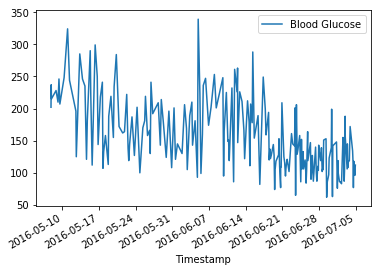

In [12]:
glucose_readings.plot.line(x = "Timestamp", y = "Blood Glucose")

The blood glucose levels fluctuate quite a bit.  Let's try looking at a single week of readings. In Pandas, we can select rows based on the value of one of the columns.  In our case, we want to find rows that have a timestamp between June 1, 2016 and June 7, 2016. Datetime objects can be compared to each other, so we need to create start and ending datetime objects.  We then create a "mask" by comparing the timestamps to the starting and ending dates.

In [14]:
start_date = dt.datetime(2016, 6, 1)
end_date = start_date + dt.timedelta(days=7)
mask = (start_date <= glucose_readings["Timestamp"]) & (glucose_readings["Timestamp"] < end_date)
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: Timestamp, dtype: bool

We can see that the mask is a Pandas Series containing boolean (True / False) values indicating whether a given row satisfies the query or not.  We can then use this to index the DataFrame.  Note that, normally, the DataFrame expects either a single column name (str) or a list of column names as the argument to `[]` -- the mask (Series) is a special case.

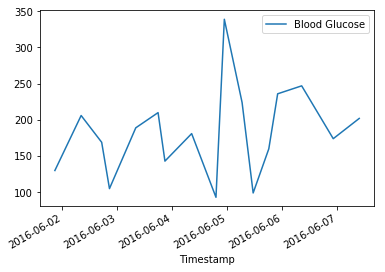

In [15]:
one_week = glucose_readings[mask]
one_week.plot.line(x = "Timestamp", y = "Blood Glucose")

From the plots of the blood glucose readings, we can generate several hypotheses:

1. Blood Glucose is Decreasing Over the Time Range of the Data Set
2. There is a Relationship between Blood Glucose and Time of Day
3. There is a Relationship between Blood Glucose and the Day of the Week

In the following subsections, we evaluate each hypothesis.

### Hypothesis 1: Blood Glucose is Decreasing Over the Time Range of the Data Set

The blood glucose appears to have a downward trend over the total time range of the data set.  Let's verify these by fitting a linear regression model and interpreting the model.

We need to convert the timestamps to a single number.  Let's find the first date, subtract this from every timestamp, and convert to days.

In [16]:
start_date = glucose_readings["Timestamp"].min()
time_deltas = glucose_readings["Timestamp"].map(lambda t: t - start_date)
days_elapsed = time_deltas.map(lambda t: t.days + t.seconds / (24. * 36000.))
days_elapsed.head(10)

0    0.000000
1    0.004097
2    0.009028
3    0.096458
4    1.034306
5    1.052153
6    1.069583
7    2.050278
8    3.016944
9    3.053819
Name: Timestamp, dtype: float64

We can now fit a linear regression model.  We use the days elapsed since the start of the data set as the independent variable and the blood glucose as the dependent variable.

In [17]:
glucose_readings["Days Elapsed"] = days_elapsed
slope, intercept, r, p_value, stderr = stats.linregress(glucose_readings["Days Elapsed"],
                                                        glucose_readings["Blood Glucose"])
print("Slope:", slope)
print("p-value:", p_value)

Slope: -1.8230144817382794
p-value: 2.59512905636245e-19


To use Panda's plotting functions, we need to add the predictions from the linear regression model to the DataFrame.  Note that the Days Elapsed is a Series.  Multiplying it by a scalar (scalar) produces another Series; this also happens when adding a scalar to the Series.

In [18]:
glucose_readings["Linear Regression"] = glucose_readings["Days Elapsed"] * slope + intercept
glucose_readings.head()

,Timestamp,Blood Glucose,Prior Activity,Days Elapsed,Linear Regression
0,2016-05-07 20:05:00,202,NaN,0.000000,218.907654
1,2016-05-07 21:04:00,237,NaN,0.004097,218.900185
2,2016-05-07 22:15:00,215,NaN,0.009028,218.891196
3,2016-05-08 19:14:00,228,NaN,0.096458,218.731809
4,2016-05-09 04:19:00,210,NaN,1.034306,217.022100


Lastly, we plot the real Blood Glucose values against the predicted values from the linear regression model.  To plot multiple lines, we need to select the independent variable (Timestamp) plus the columns (Blood Glucose, Linear Regression) we want to plot.  We then call the plot.line function, specifying which column is the independent variable.

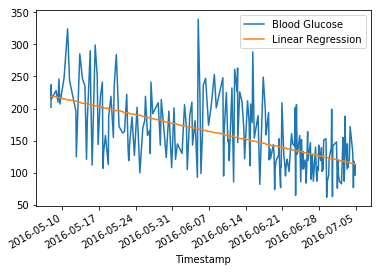

In [19]:
glucose_readings[["Timestamp", "Blood Glucose", "Linear Regression"]].plot.line(x="Timestamp")

Our linear regression model confirms that the average blood glucose does seem to be decreasing over the date range of the data set.  The p_value is clearly much less than 0.01, indicating that the model is statistically significant.  The slope is in units of glucose units per day -- we can interpret the slope to mean that the glucose levels are going down by 1.8 units per day, on average.  Lastly, when we plot the predictions from the linear regression model versus the true readings, we see that the line from the predictions clearly expose the downward trend.  We can consider our hypothesis to be validated.

### Hypothesis 2: There is a Relationship Between Blood Glucose and Time of Day

There could be a trend by time of day.  Let's make a column giving the time of day for each record by extracting the hour of the day from the timestamp and then plot it.

In [20]:
hour_of_day = glucose_readings["Timestamp"].map(lambda t: t.hour)
hour_of_day.head()

0    20
1    21
2    22
3    19
4     4
Name: Timestamp, dtype: int64

(0, 350)

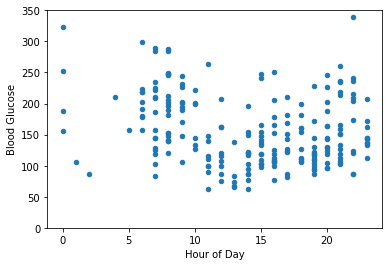

In [21]:
glucose_readings["Hour of Day"] = hour_of_day
glucose_readings.plot.scatter(x = "Hour of Day", y = "Blood Glucose")
plt.ylim([0, 350])

Our scatter plot is difficult to interpret due to how noisy the data is.  Let's try a box plot.

(0, 350)

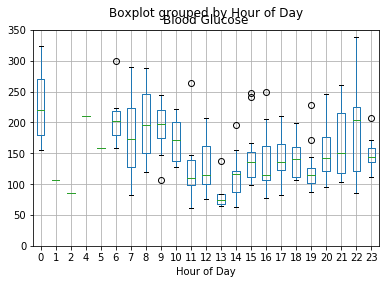

In [22]:
glucose_readings.boxplot(by = "Hour of Day", column = "Blood Glucose")
plt.ylim([0, 350])

From the boxplot, we can conclude that blood glucose varies by time of day.  It tends to be higher in the mornings (6 - 10), lower in the afternoons (11 - 15), and high again in the evenings (21 -).  We see a bumb from 11 to 12, possibly from eating lunch.  Our hypothesis is validated.

### Hypothesis 3: There is a Relationship Between Blood Glucose and Day of the Week

Lastly, we want to evaluate our hypothesis about a relationship between the blood glucose and day of the week.  Like with the time of day, we will create a new column with the day of the week of each record.  We will then using visualizations to explore the relationship between the day of the week and blood glucose readings.

In [23]:
day_of_week = glucose_readings["Timestamp"].map(lambda t: t.weekday())
day_of_week.head(10)

0    5
1    5
2    5
3    6
4    0
5    0
6    0
7    1
8    2
9    2
Name: Timestamp, dtype: int64

(0, 350)

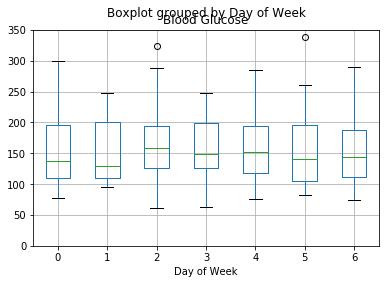

In [24]:
glucose_readings["Day of Week"] = day_of_week
glucose_readings.boxplot(by = "Day of Week", column = "Blood Glucose")
plt.ylim([0, 350])

We can conclude that the blood glucose does not vary with the day of the week.  We can reject our hypothesis as false.

## Analyzing the Effect of Prior Activities

We hypothesize that performing exercise prior to taking a glucose reading results in a lower blood glucose level. Let's explore the Prior Activity column and try to validate our hypothesis. Remember from before that Prior Activity is also an object:

In [25]:
glucose_readings.dtypes

Timestamp            datetime64[ns]
Blood Glucose                 int64
Prior Activity               object
Days Elapsed                float64
Linear Regression           float64
Hour of Day                   int64
Day of Week                   int64
dtype: object

Let's see if we can see a value other than NaN if we look at more rows.

In [26]:
glucose_readings.head(20)

,Timestamp,Blood Glucose,Prior Activity,Days Elapsed,Linear Regression,Hour of Day,Day of Week
0,2016-05-07 20:05:00,202,NaN,0.000000,218.907654,20,5
1,2016-05-07 21:04:00,237,NaN,0.004097,218.900185,21,5
2,2016-05-07 22:15:00,215,NaN,0.009028,218.891196,22,5
3,2016-05-08 19:14:00,228,NaN,0.096458,218.731809,19,6
4,2016-05-09 04:19:00,210,NaN,1.034306,217.022100,4,0
5,2016-05-09 08:36:00,246,NaN,1.052153,216.989564,8,0
6,2016-05-09 12:47:00,207,NaN,1.069583,216.957788,12,0
7,2016-05-10 08:09:00,248,NaN,2.050278,215.169968,8,1
8,2016-05-11 00:09:00,324,NaN,3.016944,213.407721,0,2
9,2016-05-11 09:00:00,244,NaN,3.053819,213.340497,9,2


Let's replace the NaNs with a dummy value.  Let's assume that NaN means that there was no prior activity.

In [27]:
filled = glucose_readings["Prior Activity"].fillna("No Activity")
filled.head(20)

0          No Activity
1          No Activity
2          No Activity
3          No Activity
4          No Activity
5          No Activity
6          No Activity
7          No Activity
8          No Activity
9          No Activity
10         No Activity
11              Biking
12         No Activity
13         No Activity
14         No Activity
15    Walking the dogs
16         No Activity
17         No Activity
18         No Activity
19              Biking
Name: Prior Activity, dtype: object

We were successful, so let's update the DataFrame.

In [28]:
glucose_readings["Prior Activity"] = filled
glucose_readings.head(20)

,Timestamp,Blood Glucose,Prior Activity,Days Elapsed,Linear Regression,Hour of Day,Day of Week
0,2016-05-07 20:05:00,202,No Activity,0.000000,218.907654,20,5
1,2016-05-07 21:04:00,237,No Activity,0.004097,218.900185,21,5
2,2016-05-07 22:15:00,215,No Activity,0.009028,218.891196,22,5
3,2016-05-08 19:14:00,228,No Activity,0.096458,218.731809,19,6
4,2016-05-09 04:19:00,210,No Activity,1.034306,217.022100,4,0
5,2016-05-09 08:36:00,246,No Activity,1.052153,216.989564,8,0
6,2016-05-09 12:47:00,207,No Activity,1.069583,216.957788,12,0
7,2016-05-10 08:09:00,248,No Activity,2.050278,215.169968,8,1
8,2016-05-11 00:09:00,324,No Activity,3.016944,213.407721,0,2
9,2016-05-11 09:00:00,244,No Activity,3.053819,213.340497,9,2


It appears that Prior Activity should be a Categorical variable type.  Let's verify by counting the number of unique elements.

In [29]:
glucose_readings["Prior Activity"].nunique()

6

It does seem like we have a categorical value.  Let's try converting it.

In [30]:
glucose_readings["Prior Activity"].astype("category").head()

0    No Activity
1    No Activity
2    No Activity
3    No Activity
4    No Activity
Name: Prior Activity, dtype: category
Categories (6, object): [Biking, Kayaking, Mow the lawn, No Activity, Walking, Walking the dogs]

Our conversion appears to be successful.  Pandas reports that it is a category with 6 values.  Let's update our DataFrame.

In [31]:
converted = glucose_readings["Prior Activity"].astype("category")
glucose_readings["Prior Activity"] = converted
glucose_readings.head(20)

,Timestamp,Blood Glucose,Prior Activity,Days Elapsed,Linear Regression,Hour of Day,Day of Week
0,2016-05-07 20:05:00,202,No Activity,0.000000,218.907654,20,5
1,2016-05-07 21:04:00,237,No Activity,0.004097,218.900185,21,5
2,2016-05-07 22:15:00,215,No Activity,0.009028,218.891196,22,5
3,2016-05-08 19:14:00,228,No Activity,0.096458,218.731809,19,6
4,2016-05-09 04:19:00,210,No Activity,1.034306,217.022100,4,0
5,2016-05-09 08:36:00,246,No Activity,1.052153,216.989564,8,0
6,2016-05-09 12:47:00,207,No Activity,1.069583,216.957788,12,0
7,2016-05-10 08:09:00,248,No Activity,2.050278,215.169968,8,1
8,2016-05-11 00:09:00,324,No Activity,3.016944,213.407721,0,2
9,2016-05-11 09:00:00,244,No Activity,3.053819,213.340497,9,2


Lastly, let's use a boxplot to look at the distribution of blood glucose readings associated with each activity.

(0, 350)

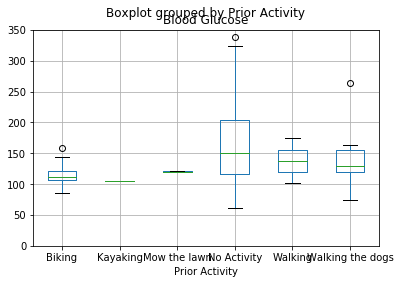

In [32]:
glucose_readings.boxplot(by = "Prior Activity", column = "Blood Glucose")
plt.ylim([0, 350])

The distributions associated with each prior activity vary quite a bit.  Blood glucose readings taken without a priory activity appear to be higher versus when we perform an activity.  Kayaking seems to result in the lowest blood guclose level, while biking is the second lowest.